# Bootcalib code for r camera

In [ ]:
%matplotlib inline

In [1]:
# imports
try:
    import seaborn as sns; sns.set(context="notebook",font_scale=2)
except:
    pass

from desispec import bootcalib as desiboot
from desiutil import funcfits as dufits
from astropy.io import fits
from astropy.stats import sigma_clip

import numpy as np
from astropy.modeling import models, fitting

/Users/xavier/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## r camera

### Flat tracing

#### Read flat

In [2]:
fiberflat = '/Users/xavier/DESI/Wavelengths/pix-r0-00000001.fits'
flat_hdu = fits.open(fiberflat)
header = flat_hdu[0].header
flat = flat_hdu[0].data
ny = flat.shape[0]

#### Find fibers

In [3]:
xpk, ypos, cut = desiboot.find_fiber_peaks(flat)

INFO:bootcalib.py:672:find_fiber_peaks: starting


INFO:DESI:starting


INFO:bootcalib.py:709:find_fiber_peaks: Found 500 fibers


INFO:DESI:Found 500 fibers


INFO:bootcalib.py:717:find_fiber_peaks: Found 20 bundles


INFO:DESI:Found 20 bundles


In [4]:
tst = True
if tst:
    xpk = xpk[0:5]

In [ ]:
reload(desiboot)
desiboot.qa_fiber_peaks(xpk, cut)

#### Trace the fiber flat spectra

In [5]:
# Crude first
xset, xerr = desiboot.trace_crude_init(flat,xpk,ypos)
# Polynomial fits
xfit, fdicts = desiboot.fit_traces(xset,xerr)

In [ ]:
# QA
desiboot.qa_fiber_Dx(xfit, fdicts)

#### Model the PSF with Gaussian

In [6]:
gauss = desiboot.fiber_gauss(flat,xfit,xerr)

INFO:bootcalib.py:594:fiber_gauss: Working on fiber 0 of 5


INFO:DESI:Working on fiber 0 of 5


In [ ]:
reload(desiboot)
desiboot.qa_fiber_gauss(gauss)

### Arc

#### Wavelength info

In [7]:
import desimodel.io

In [8]:
desi_psf = desimodel.io.load_psf('r')

In [27]:
wave4 = desi_psf.wavelength(4,np.arange(desi_psf.npix_y))

In [31]:
wave4[1692]

6506.600473176205

In [149]:
wave4[2451]

6907.4548001103185

In [28]:
wave4[2493]

6929.2715774131439

In [67]:
wave4[2692]

7032.0935157913

In [49]:
wave4[2969]

7173.6943327592153

In [11]:
np.min(wave0), np.max(wave0)

(5569.6355533734004, 7745.6051833427209)

In [12]:
np.abs(wave0[0]-wave0[-1])/desi_psf.npix_y

0.52712442586466102

#### Read arc

In [13]:
arcfile = '/Users/xavier/DESI/Wavelengths/pix-r0-00000000.fits'
arc_hdu = fits.open(arcfile)
arc = arc_hdu[0].data

#### Extract arc

In [14]:
all_spec = desiboot.extract_sngfibers_gaussianpsf(arc,xfit,gauss,verbose=False)

#### Linelist

In [193]:
reload(desiboot)
camera = header['CAMERA']
llist = desiboot.load_arcline_list(camera)
dlamb, wmark, gd_lines, line_guess = desiboot.load_gdarc_lines(camera)

INFO:bootcalib.py:458:load_arcline_list: Rejecting select HgI lines


INFO:DESI:Rejecting select HgI lines


INFO:bootcalib.py:458:load_arcline_list: Rejecting select NeI lines


INFO:DESI:Rejecting select NeI lines


In [194]:
gd_lines

array([ 5769.598 ,  5852.4878,  5944.834 ,  6143.062 ,  6402.246 ,
        6506.528 ,  6678.2766,  6717.043 ,  6929.4672,  7032.4128,
        7173.938 ,  7245.1665,  7438.898 ])

#### Solve

In [195]:
ii=4

#### Find Lines

In [196]:
spec = all_spec[:,ii]
# Find Lines
pixpk = desiboot.find_arc_lines(spec)

In [197]:
pixpk

array([  340.20175748,   349.39823329,   386.90565798,   497.12220262,
         549.7341551 ,   662.71309491,   717.95235434,   816.36200462,
         896.70339584,   936.28627496,   995.33931158,  1021.67117306,
        1059.11275615,  1157.25565836,  1247.54257909,  1317.92608131,
        1372.58728901,  1462.29741387,  1497.97477993,  1691.87102916,
        1741.08729611,  1864.8769706 ,  2014.12979678,  2087.61827821,
        2451.0499158 ,  2493.34600895,  2676.34885371,  2692.64293513,
        2744.56022266,  2969.55198639,  3110.1388375 ,  3497.25654999,
        3564.97170851,  3598.20800884,  3693.26997004,  3710.11410812,
        3895.84128468])

In [198]:
#xdb.xplot(spec)

#### Match a set of 5 gd_lines to detected lines

In [212]:
reload(desiboot)
id_dict = desiboot.id_arc_lines(pixpk,gd_lines,dlamb,wmark,line_guess=line_guess)#line_guess)

In [213]:
id_dict

{u'dlamb': 0.527,
 u'first_id_idx': [19, 22, 23, 25, 27],
 u'first_id_pix': array([ 1691.87102916,  2014.12979678,  2087.61827821,  2493.34600895,
         2692.64293513]),
 u'first_id_wave': array([ 6506.528 ,  6678.2766,  6717.043 ,  6929.4672,  7032.4128]),
 u'fit': {'coeff': array([ -7.27380983e+03,   4.46236920e-01,   1.86590813e-05]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 23,
 u'icen': 7,
 'im1': 22,
 'im2': 19,
 'ip1': 25,
 'ip2': 27,
 'rms': 0.069454506158127594,
 u'wmark': 6717.043}

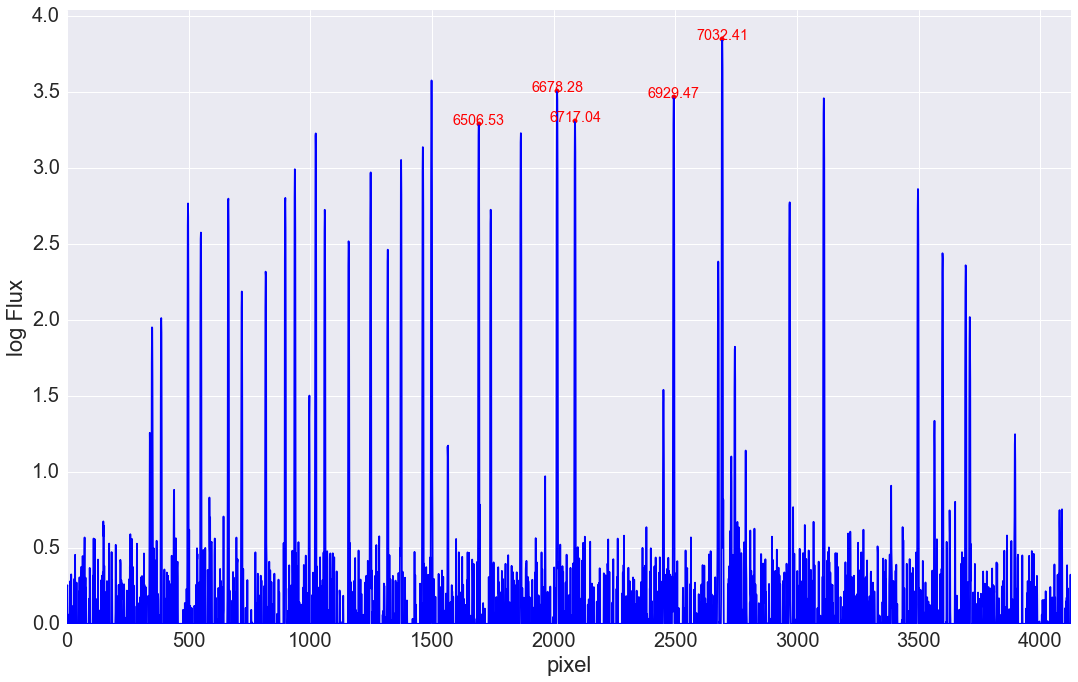

In [214]:
# IDs
plt.clf()
plt.figure(figsize=(18, 11))

yspec = np.log10(np.maximum(spec,1))
xpk = id_dict['first_id_pix']
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['first_id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['first_id_wave'][jj]),
         ha='center',color='red',size='x-large')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
#plt.xlim(2650., 2750)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

#### Find the other good ones

In [202]:
desiboot.add_gdarc_lines(id_dict, pixpk, gd_lines)

In [203]:
id_dict

{u'dlamb': 0.527,
 u'first_fit': {'coeff': array([ -7.27380983e+03,   4.46236920e-01,   1.86590813e-05]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 u'first_id_idx': [19, 22, 23, 25, 27],
 u'first_id_pix': array([ 1691.87102916,  2014.12979678,  2087.61827821,  2493.34600895,
         2692.64293513]),
 u'first_id_wave': array([ 6506.528 ,  6678.2766,  6717.043 ,  6929.4672,  7032.4128]),
 u'fit': {'coeff': array([ -1.06429692e+04,   1.19215407e+00,  -3.63755931e-05,
           1.35319491e-09]),
  'func': u'polynomial',
  'order': 3,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 23,
 u'icen': 7,
 u'id_idx': [5, 11, 18, 19, 22, 23, 25, 27, 29, 30, 31],
 u'id_pix': [662.71309491414252,
  1021.6711730591247,
  1497.9747799297438,
  1691.8710291610926,
  2014.1297967788587,
  2087.6182782053656,
  2493.3460089453315,
  2692.6429351338438,
  2969.5519863947907,
  3110.1388375032575,
  3497.2565499931102],
 u'id_wave': [5944.8339999999998,
  6143.0619999999999,
  6402.2

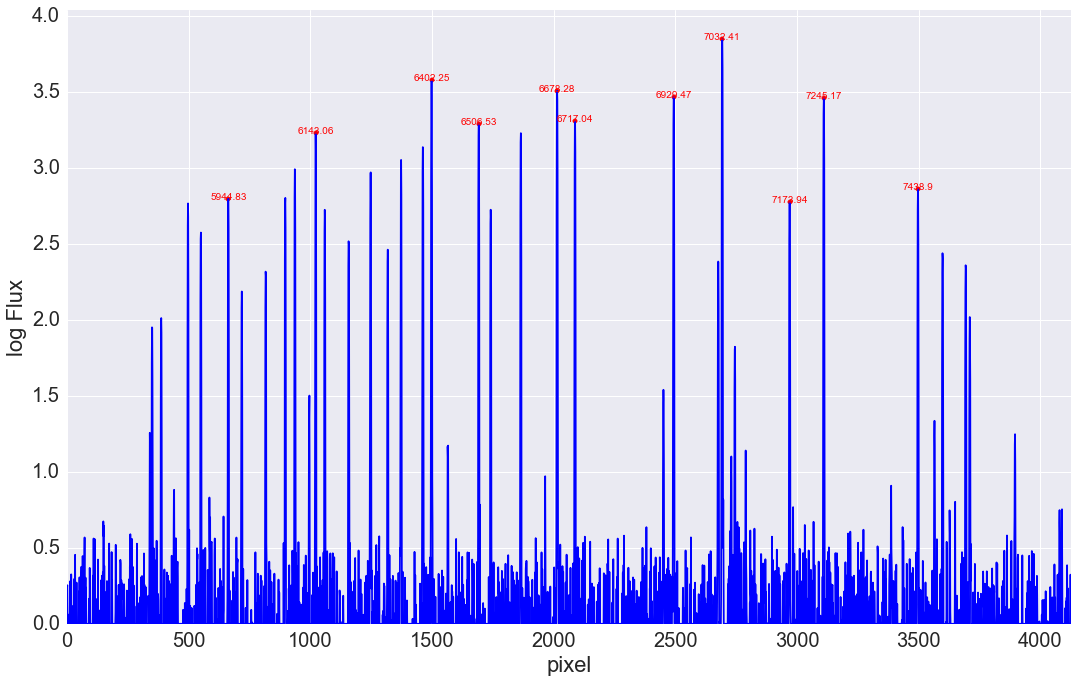

In [204]:
# IDs
plt.clf()
plt.figure(figsize=(18, 11))

yspec = np.log10(np.maximum(spec,1))
xpk = id_dict['id_pix']
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

#### Now the rest

In [205]:
desiboot.id_remainder(id_dict, pixpk, llist)

In [208]:
id_dict['rms']

0.07717510516330725

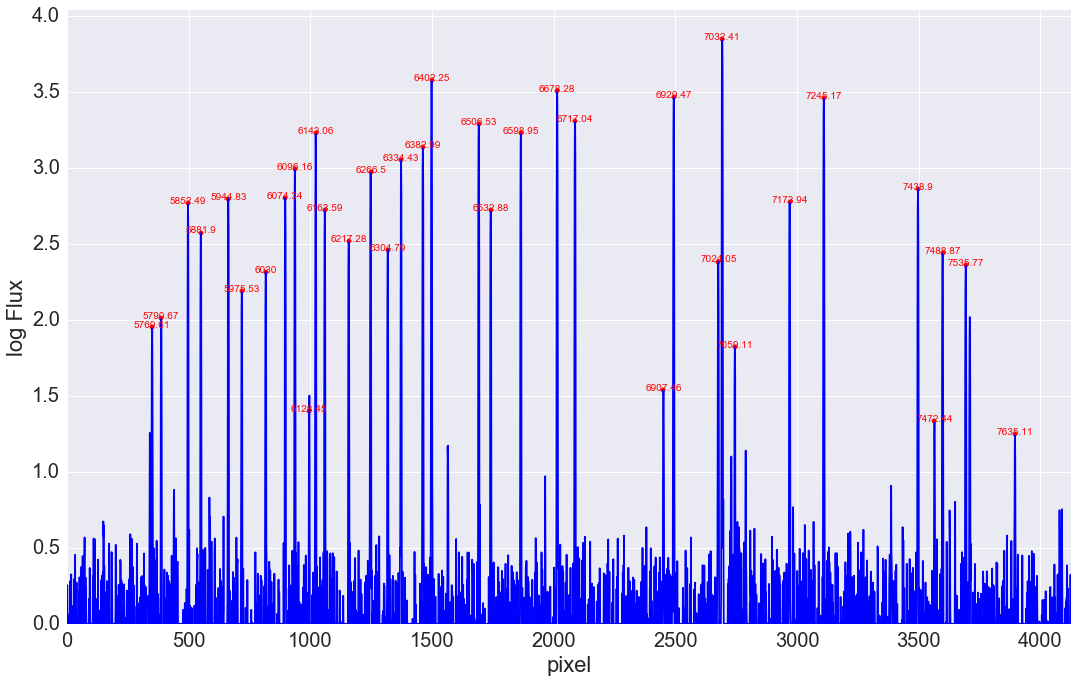

In [209]:
# IDs
plt.clf()
plt.figure(figsize=(18, 11))

yspec = np.log10(np.maximum(spec,1))
xpk = id_dict['id_pix']
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

#### Final fit wave vs. pix too

In [210]:
final_fit, mask = dufits.iter_fit(np.array(id_dict['id_wave']), np.array(id_dict['id_pix']), 'polynomial', 3, xmin=0., xmax=1.)
rms = np.sqrt(np.mean((dufits.func_val(np.array(id_dict['id_wave'])[mask==0], final_fit)-np.array(id_dict['id_pix'])[mask==0])**2))
final_fit_pix,mask2 = dufits.iter_fit(np.array(id_dict['id_pix']), np.array(id_dict['id_wave']),'legendre',4, niter=5) 

In [211]:
print("RMS = {:g}".format(rms))

RMS = 0.171506
